# Project 242

## Import

In [1098]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [1099]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [1100]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


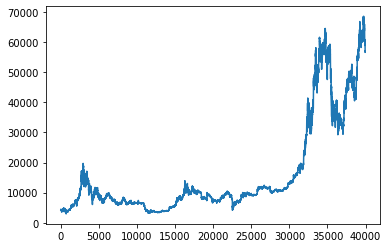

In [1101]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [1102]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})

Here, we can decide to add features ...

In [1103]:
# Add features
data = add_technical_indicators(data, lookback_period=30)[30:]

In [1104]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [1105]:
# Split data
train_data, test_data = split_data(data, split=0.25)


In [1106]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [1107]:
# Add Signal
train = add_signal(train_data, 0.001)
test = add_signal(test_data, 0.001)

In [1108]:
train = prepare_data_2D_format(train_data, lookback_period = 2)
test = prepare_data_2D_format(test_data, lookback_period = 2, undersample = False)
test = test[:-2]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


## II. Model

### A. Predicting if a return will be higher than the fees

In [1109]:
train['Signal1'] = (train['Signal']>=0).apply(int)
test['Signal1'] = (test['Signal']>=0).apply(int)

In [1110]:
removed = ['Signal', 'Return', 'Signal1']
str_formula = 'Signal1 ~ '
for feat in train.columns:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [1111]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

         Current function value: 0.626783
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                23748
Model:                          Logit   Df Residuals:                    23721
Method:                           MLE   Df Model:                           26
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                 0.01529
Time:                        22:06:22   Log-Likelihood:                -14885.
converged:                      False   LL-Null:                       -15116.
Covariance Type:            nonrobust   LLR p-value:                 2.218e-81
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1700      0.150      1.134      0.257      -0.124       0.464
open_day_minus10       -0.0002      0.

/Users/noemielevy/comparators/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


We perform feature selection using the p-value

In [1034]:
## remove Volume_day_minus10:
removed.append('Volume_day_minus10')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

         Current function value: 0.179910
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Signal1   No. Observations:                29896
Model:                          Logit   Df Residuals:                    29775
Method:                           MLE   Df Model:                          120
Date:                Mon, 06 Dec 2021   Pseudo R-squ.:                 0.08974
Time:                        21:58:50   Log-Likelihood:                -5378.6
converged:                      False   LL-Null:                       -5908.9
Covariance Type:            nonrobust   LLR p-value:                2.292e-150
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0321      0.337      6.038      0.000       1.372       2.692
open_day_minus10        0.0002      0.

/Users/noemielevy/comparators/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [1035]:
## remove BB_high_day_minus8:
removed.append('BB_high_day_minus8')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

KeyboardInterrupt: 

In [ ]:
## remove close_day_minus9:
removed.append('close_day_minus9')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove RSI_day_minus9:
removed.append('RSI_day_minus9')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove all MOM_day_minus10:
removed.append('MOM_day_minus10')
removed.append('MOM_day_minus9')
removed.append('MOM_day_minus8')
removed.append('MOM_day_minus7')
removed.append('MOM_day_minus6')
removed.append('MOM_day_minus5')
removed.append('MOM_day_minus4')
removed.append('MOM_day_minus3')
removed.append('MOM_day_minus2')
removed.append('MOM_day_minus1')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus8:
removed.append('EMA_day_minus8')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus1:
removed.append('EMA_day_minus1')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove MACD_day_minus9:
removed.append('MACD_day_minus9')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus6:
removed.append('EMA_day_minus6')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus5:
removed.append('EMA_day_minus5')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus2:
removed.append('EMA_day_minus2')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove BB_high_day_minus2:
removed.append('BB_high_day_minus2')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus7:
removed.append('EMA_day_minus7')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
## remove EMA_day_minus8:
removed.append('EMA_day_minus8')
str_formula = 'Signal1 ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg1 = smf.logit(formula  = str_formula, data = train).fit()

print(reg1.summary())

In [ ]:
y_prob = reg.predict(test)

p75 = y_prob.mean() + y_prob.std()/3
p25 = y_prob.mean() - y_prob.std()/3
def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < p25: return -1
    if x > p75: return 1
    return 0
y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]), 
        '-1': len([x for x in y_pred if x == -1]), 
        '0': len([x for x in y_pred if x == 0])}
print(freq)

### 3. Test prediction model

In [ ]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [ ]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

### III. Strategy

### 1. Get data ready for backtesting

In [ ]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

In [ ]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [ ]:
strat = Strategy(cash=500, fees=0.001)

In [ ]:
strat.run(signal_crop, close_crop, verbose=False)

In [ ]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

In [ ]:
strat.visualize()

### 3. Test performance startegy

In [ ]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [ ]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)